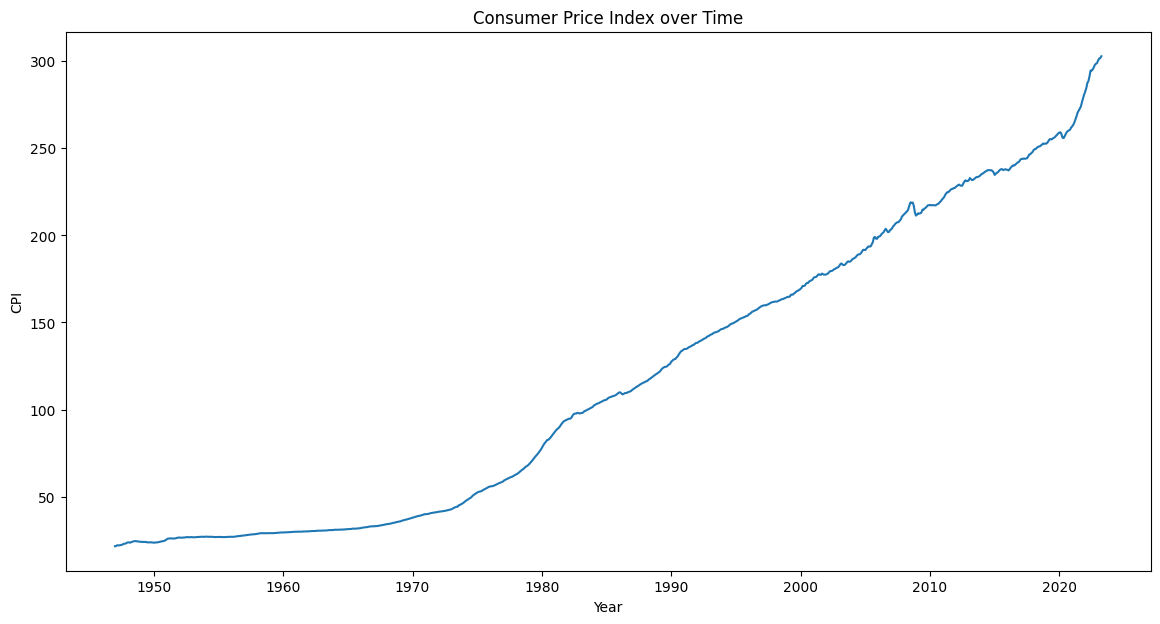

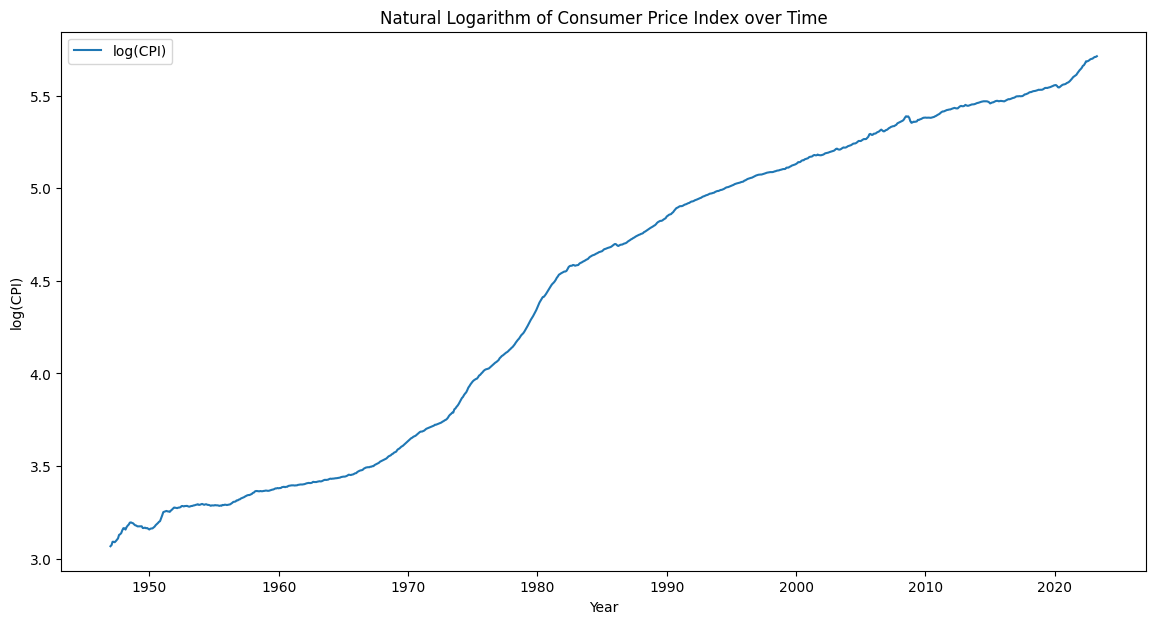

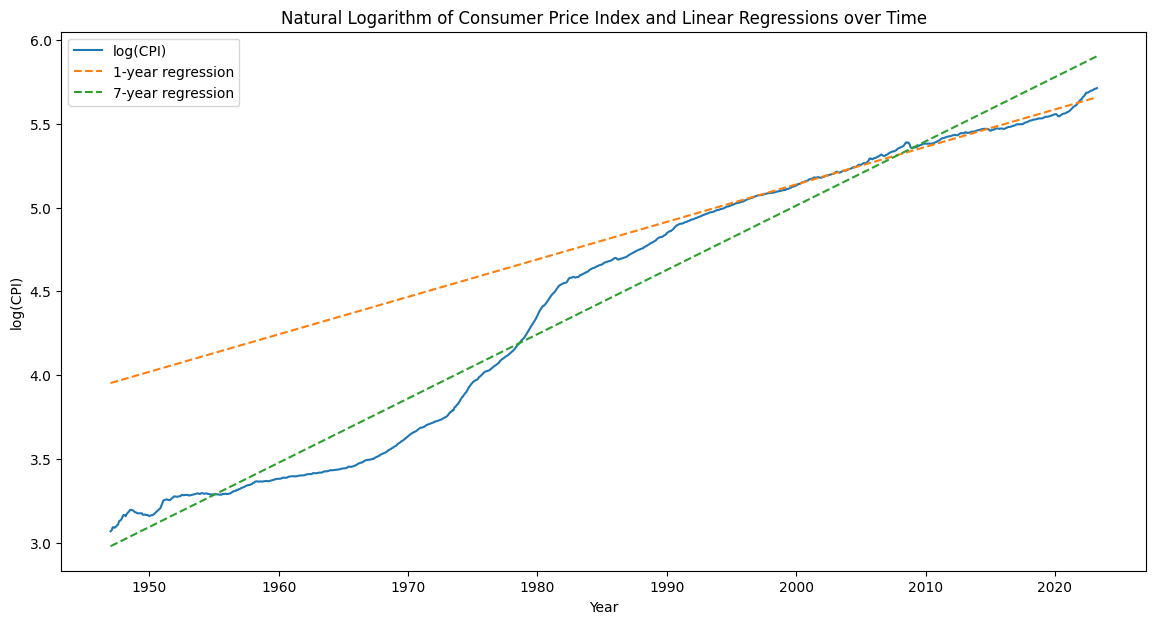

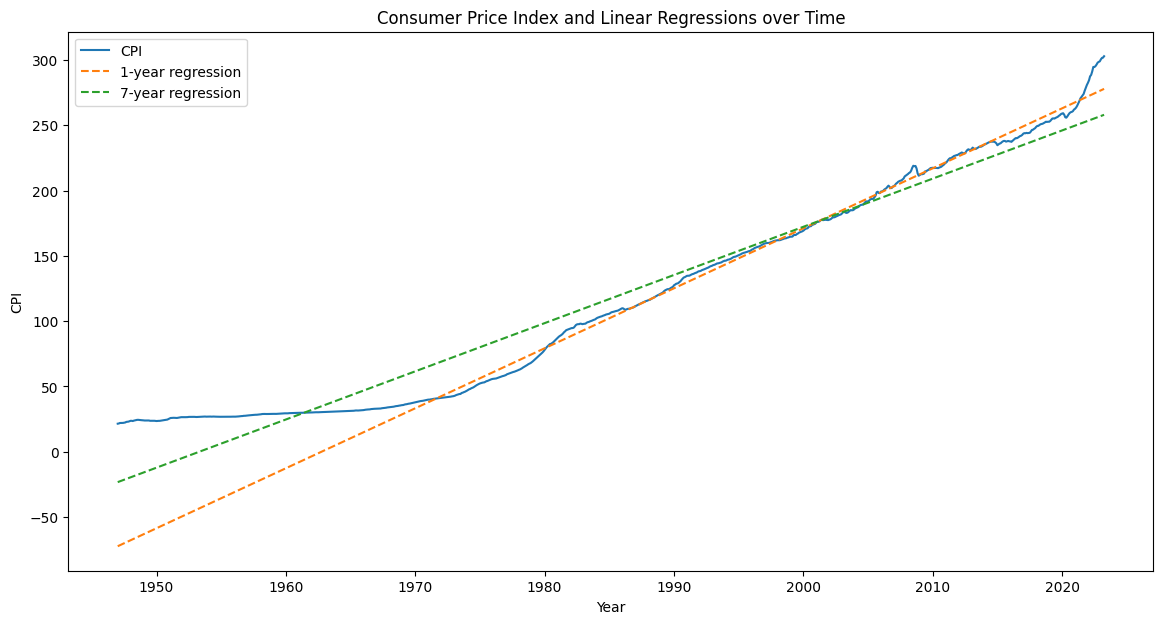

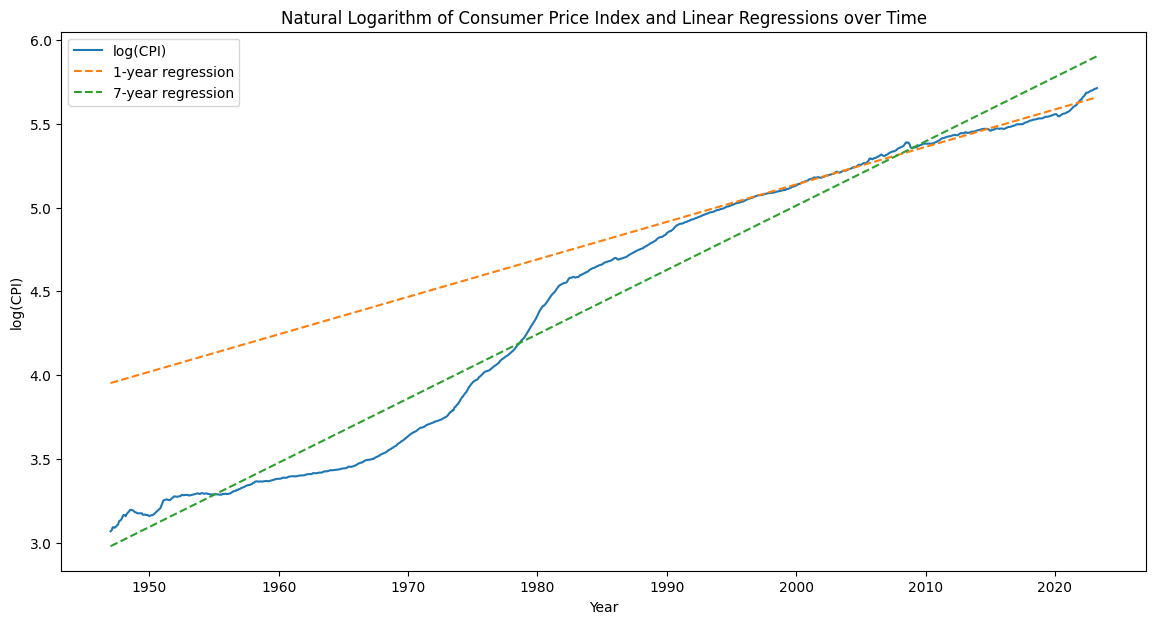

In [7]:
# Now import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
# Import the numpy library
import numpy as np
# Import necessary libraries
from sklearn.linear_model import LinearRegression

# Linear regression model requires 2D array, so we'll convert our dates to numbers and reshape
X = cpi_df.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1) # independent variable (time)
y = cpi_df['log_CPI'].values # dependent variable (log_CPI)

# Train the 1-year model
model_1 = LinearRegression()
model_1.fit(X[-365:], y[-365:]) # Use the last 365 days of data

# Train the 7-year model
model_7 = LinearRegression()
model_7.fit(X[-365*7:], y[-365*7:]) # Use the last 7*365 days of data

# Compute predictions
y_pred_1 = model_1.predict(X)
y_pred_7 = model_7.predict(X)

# Add predictions to the DataFrame
cpi_df['1_year_regression'] = y_pred_1
cpi_df['7_year_regression'] = y_pred_7


# You should replace 'your_api_key_here' with your actual FRED API key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi_data = fred.get_series('CPIAUCSL')

# Convert the series into a DataFrame
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])

# Check the first few rows of the DataFrame
cpi_df.head()

# Plot the CPI data
plt.figure(figsize=(14,7))
plt.plot(cpi_df.index, cpi_df['CPI'])
plt.title('Consumer Price Index over Time')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.show()


# Compute the natural logarithm of the CPI
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Check the first few rows of the DataFrame
cpi_df.head()


# Plot the natural log of the CPI data
plt.figure(figsize=(14,7))
plt.plot(cpi_df.index, cpi_df['log_CPI'], label='log(CPI)')
plt.title('Natural Logarithm of Consumer Price Index over Time')
plt.xlabel('Year')
plt.ylabel('log(CPI)')
plt.legend()
plt.show()


# Linear regression model requires 2D array, so we'll convert our dates to numbers and reshape
X = cpi_df.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1) # independent variable (time)
y = cpi_df['log_CPI'].values # dependent variable (log_CPI)

# Train the 1-year model
model_1 = LinearRegression()
model_1.fit(X[-365:], y[-365:]) # Use the last 365 days of data

# Train the 7-year model
model_7 = LinearRegression()
model_7.fit(X[-365*7:], y[-365*7:]) # Use the last 7*365 days of data

# Compute predictions
y_pred_1 = model_1.predict(X)
y_pred_7 = model_7.predict(X)

# Add predictions to the DataFrame
cpi_df['1_year_regression'] = y_pred_1
cpi_df['7_year_regression'] = y_pred_7

# Plot the natural log of the CPI data and the regressions
plt.figure(figsize=(14,7))
plt.plot(cpi_df.index, cpi_df['log_CPI'], label='log(CPI)')
plt.plot(cpi_df.index, cpi_df['1_year_regression'], label='1-year regression', linestyle='--')
plt.plot(cpi_df.index, cpi_df['7_year_regression'], label='7-year regression', linestyle='--')
plt.title('Natural Logarithm of Consumer Price Index and Linear Regressions over Time')
plt.xlabel('Year')
plt.ylabel('log(CPI)')
plt.legend()
plt.show()


# In this case, y will be the original CPI data
y = cpi_df['CPI'].values 

# Train the 1-year model
model_1 = LinearRegression()
model_1.fit(X[-365:], y[-365:]) 

# Train the 7-year model
model_7 = LinearRegression()
model_7.fit(X[-365*7:], y[-365*7:]) 

# Compute predictions
y_pred_1 = model_1.predict(X)
y_pred_7 = model_7.predict(X)

# Add predictions to the DataFrame
cpi_df['1_year_regression'] = y_pred_1
cpi_df['7_year_regression'] = y_pred_7

# Plot the CPI data and the regressions
plt.figure(figsize=(14,7))
plt.plot(cpi_df.index, cpi_df['CPI'], label='CPI')
plt.plot(cpi_df.index, cpi_df['1_year_regression'], label='1-year regression', linestyle='--')
plt.plot(cpi_df.index, cpi_df['7_year_regression'], label='7-year regression', linestyle='--')
plt.title('Consumer Price Index and Linear Regressions over Time')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.legend()
plt.show()


# Use numpy to log-transform the 'CPI' column
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Assign your independent and dependent variables
X = cpi_df.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = cpi_df['log_CPI'].values 

# Train the models
model_1 = LinearRegression()
model_1.fit(X[-365:], y[-365:]) 

model_7 = LinearRegression()
model_7.fit(X[-365*7:], y[-365*7:]) 

# Compute predictions
y_pred_1 = model_1.predict(X)
y_pred_7 = model_7.predict(X)

# Add predictions to the DataFrame
cpi_df['1_year_regression'] = y_pred_1
cpi_df['7_year_regression'] = y_pred_7


# Plot the natural log of the CPI data and the regressions
plt.figure(figsize=(14,7))
plt.plot(cpi_df.index, cpi_df['log_CPI'], label='log(CPI)')
plt.plot(cpi_df.index, cpi_df['1_year_regression'], label='1-year regression', linestyle='--')
plt.plot(cpi_df.index, cpi_df['7_year_regression'], label='7-year regression', linestyle='--')
plt.title('Natural Logarithm of Consumer Price Index and Linear Regressions over Time')
plt.xlabel('Year')
plt.ylabel('log(CPI)')
plt.legend()
plt.show()
